# What To Learn?
## Integral field Spectrscopy & Astronomical FITS Data cube visualization
#### ***Integral Field Unit (IFU) spectroscopy is a powerful observational technique in astronomy that allows astronomers to obtain spectra(FLUX vs Wavelength) for every point (or small region) across a two-dimensional(X,Y) field of view***
#### 2. Where as Single slit spectroscopy (often just called slit spectroscopy) is a fundamental technique in astronomical and laboratory spectroscopy where light from a source passes through a narrow slit 
#### 3D data cube:
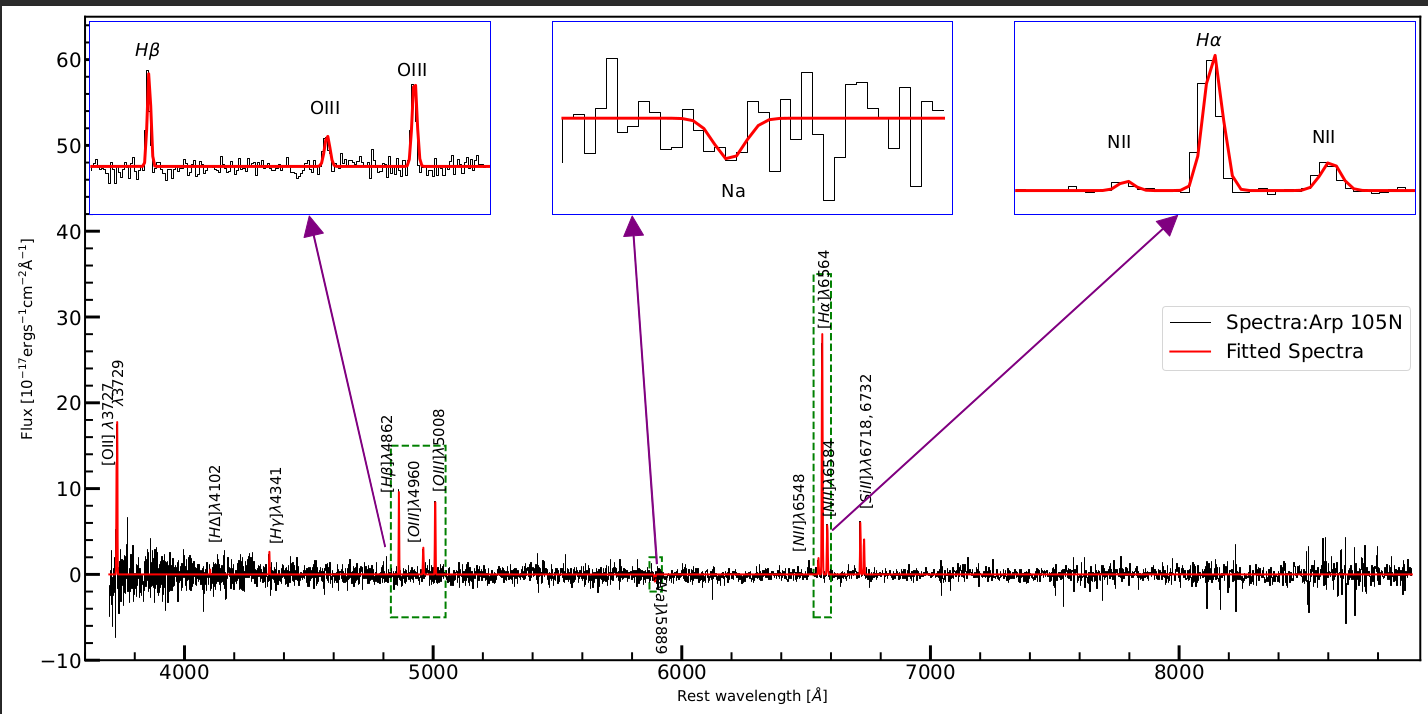
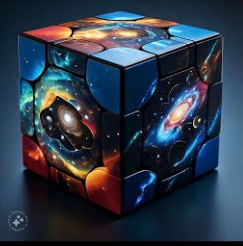
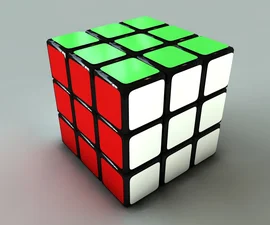![image.png]

#### X and Y: Spatial dimensions (like an image) called "SPAXEL" or Spextral Pixel

#### Z: Spectral dimension (wavelength) λ

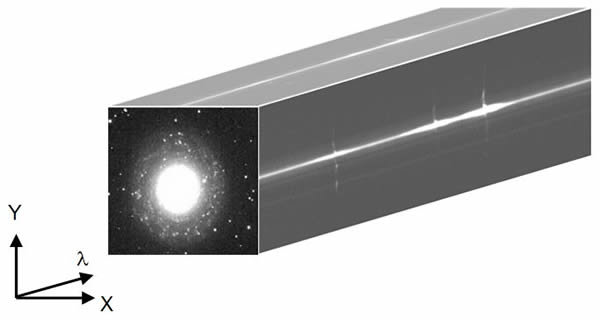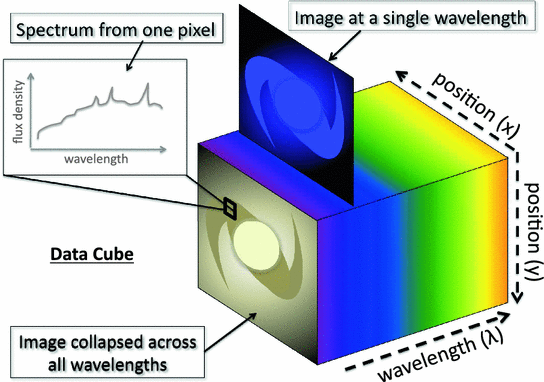!


### ✅ Advantages of IFU Spectroscopy
### 1. Spatially Resolved Spectra
Each spaxel has a full spectrum → you get a data cube: (x, y, λ)

Allows you to study how physical properties change across an object (e.g., a galaxy)

E.g., You can map velocity, metallicity, star formation, and ionization across a galaxy, not just from a single line of sight.

### 2. No Need for Slit Alignment
In single-slit spectroscopy, precise alignment is critical

IFUs observe everything in the field of view at once → reduces pointing errors and losses

### 3. Efficient Use of Telescope Time
With a single pointing, you get multiple spectra across a region

Great for complex or extended sources (e.g., galaxies, nebulae, mergers)


#### Step-1: Data Cube Access/Downloding : Use data cube fits file: "manga-10215-1902-LINCUBE.fits" at redshift=?

In [ ]:
import urllib.request
import os

# Download the FITS file if not already present
if not os.path.exists("manga-10215-1902-LINCUBE.fits"):
    url = "https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/10215/stack/manga-10215-1902-LINCUBE.fits"
    urllib.request.urlretrieve(url, "manga-10215-1902-LINCUBE.fits")

#### Step-2: Import library

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import simple_norm
import matplotlib.colors as colors
from astropy.cosmology import FlatLambdaCDM
import warnings
warnings.filterwarnings('ignore')  # Suppress some astropy warnings

#### Step-3: Read FITS Data cube of Galaxy from SDSS MANGA survey

In [ ]:
# Open the FITS file
with fits.open("manga-10215-1902-LINCUBE.fits") as hdul:
    hdul.info()  # Show the structure of the FITS file
    data_cube = hdul

#### Step-4: Extract FITS Cube information

In [ ]:
# Get basic information
primary_header = data_cube[0].header
flux_header = data_cube[1].header
flux_data = data_cube[1].data
error_data = data_cube[2].data
wavelength = data_cube[4].data

# Print some header information
print("\nPrimary Header Keywords:")
print(f"Object: {primary_header.get('OBJECT', 'N/A')}")
print(f"Redshift: {primary_header.get('Z', 'N/A')}")
print(f"RA: {primary_header.get('OBJRA', 'N/A')}")
print(f"DEC: {primary_header.get('OBJDEC', 'N/A')}")

# Get the WCS (World Coordinate System) information
wcs = WCS(flux_header)

# The redshift for this galaxy is approximately 0.03 (from SDSS data)
z = 0.03

#### Step-5: Extract cube Data From HDUs: Flux, Wavelength, Flux error etc

In [ ]:
# Extract the flux, error, and wavelength data
flux = data_cube['FLUX'].data  # Flux in 10^-17 erg/s/cm^2/Å/spaxel
ivar = data_cube['IVAR'].data  # Inverse variance
error = np.sqrt(1/np.maximum(ivar, 1e-10))  # Proper error estimation
wavelength = data_cube['WAVE'].data  # Wavelength in Å

# Get the shape of the data cube
n_waves, n_y, n_x = flux.shape
print(f"\nData cube shape: {flux.shape} (wavelength, y, x)")
print(f"Wavelength range: {wavelength[0]:.1f} Å to {wavelength[-1]:.1f} Å")

#### Step-6: Visualize Galaxy flux map  along Z: wavelength axis

In [ ]:
# Create a grid of wavelength slices to visualize
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
wavelength_indices = np.linspace(0, n_waves-1, 9, dtype=int)

for ax, idx in zip(axes.flat, wavelength_indices):
    wave = wavelength[idx]
    flux_slice = flux[idx, :, :]
    
    # Use logarithmic scaling for better visualization
    norm = simple_norm(flux_slice, stretch='log', min_percent=1, max_percent=99)
    ax.imshow(flux_slice, origin='lower', norm=norm, cmap='viridis')
    ax.set_title(f'{wave:.1f} Å')
    ax.axis('off')

plt.suptitle('Flux Slices at Different Wavelengths', y=0.92, fontsize=16)
plt.tight_layout()
plt.show()

#### Step-7:  Visualize Galaxy spectra at each spaxel(x,y) in observed frame

In [ ]:
# Select some representative spaxels
spaxel_positions = [(15, 15), (25, 25), (35, 35), (15, 35), (35, 15)]

plt.figure(figsize=(12, 6))
for i, (y, x) in enumerate(spaxel_positions):
    spectrum = flux[:, y, x]
    plt.plot(wavelength, spectrum, label=f'Spaxel (y={y}, x={x})')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (10$^{-17}$ erg/s/cm$^2$/Å)')
plt.title('Spectra at Different Spaxels (Observed Frame)')
plt.legend()
plt.grid(True)
plt.show()

#### Step-7:.1  Visualize Galaxy spectra at each spaxel(x,y) in REST frame
$${\LARGE
\lambda_{\text{Rest}} = \frac{\lambda_{\text{observed}}}{1 + z}
}$$

In [ ]:
# Convert to rest frame wavelength
rest_wavelength = wavelength / (1 + z)

plt.figure(figsize=(12, 6))
for i, (y, x) in enumerate(spaxel_positions):
    spectrum = flux[:, y, x]
    plt.plot(rest_wavelength, spectrum, label=f'Spaxel (y={y}, x={x})')

plt.xlabel('Rest Wavelength (Å)')
plt.ylabel('Flux (10$^{-17}$ erg/s/cm$^2$/Å)')
plt.title('Spectra at Different Spaxels (Rest Frame)')
plt.legend()
plt.grid(True)
plt.show()

#### Step-8: Create a white light

In [ ]:
# Sum along the wavelength axis to create a white light image
white_light = np.sum(flux, axis=0)

plt.figure(figsize=(8, 8))
norm = simple_norm(white_light, stretch='log', min_percent=1, max_percent=99.9)
plt.imshow(white_light, origin='lower', norm=norm, cmap='viridis')
plt.colorbar(label='Total Flux (10$^{-17}$ erg/s/cm$^2$)')
plt.title('White Light Image (Sum Over All Wavelengths)')
plt.axis('off')
plt.show()

#### Step-9: Estimate SNR per Z pixel 

In [ ]:
# Calculate SNR (Signal-to-Noise Ratio)
snr = flux / error

# Calculate mean SNR per wavelength
mean_snr_per_wave = np.nanmean(snr, axis=(1, 2))

plt.figure(figsize=(12, 5))
plt.plot(wavelength, mean_snr_per_wave)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Mean SNR')
plt.title('Mean SNR vs Wavelength')
plt.grid(True)
plt.show()

#### Step-10: Visualize Galaxy SNR map along Z: wavelength axis

In [ ]:
# Create SNR maps at specific wavelengths
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
wavelength_indices = np.linspace(0, n_waves-1, 9, dtype=int)

for ax, idx in zip(axes.flat, wavelength_indices):
    wave = wavelength[idx]
    snr_slice = snr[idx, :, :]
    
    # Clip extreme values for better visualization
    snr_slice = np.clip(snr_slice, 0, 20)
    ax.imshow(snr_slice, origin='lower', vmin=0, vmax=20, cmap='plasma')
    ax.set_title(f'{wave:.1f} Å')
    ax.axis('off')

plt.suptitle('SNR Maps at Different Wavelengths', y=0.92, fontsize=16)
plt.tight_layout()
plt.show()

#### Step-11: Visualize Galaxy SNR at each spaxel(x,y)

In [ ]:
plt.figure(figsize=(12, 6))
for i, (y, x) in enumerate(spaxel_positions):
    spaxel_snr = snr[:, y, x]
    plt.plot(wavelength, spaxel_snr, label=f'Spaxel (y={y}, x={x})')

plt.xlabel('Wavelength (Å)')
plt.ylabel('SNR')
plt.title('SNR at Different Spaxels')
plt.legend()
plt.grid(True)
plt.ylim(0, 20)  # Limit y-axis for better visualization
plt.show()

#### Step-12: Stacking of Spaxel spectra

In [ ]:
# Stack spectra within a circular aperture
center_y, center_x = n_y // 2, n_x // 2
radius = 10  # in spaxels

# Create a grid of coordinates
yy, xx = np.mgrid[:n_y, :n_x]
distance_from_center = np.sqrt((yy - center_y)**2 + (xx - center_x)**2)

# Create a mask for the aperture
aperture_mask = distance_from_center <= radius

# Stack the spectra within the aperture
stacked_spectrum = np.nansum(flux * aperture_mask[np.newaxis, :, :], axis=(1, 2)) / np.sum(aperture_mask)

plt.figure(figsize=(12, 6))
plt.plot(wavelength, stacked_spectrum)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Stacked Flux (10$^{-17}$ erg/s/cm$^2$/Å)')
plt.title(f'Stacked Spectrum Within r={radius} spaxels')
plt.grid(True)
plt.show()

#### Step-13: Stacking of Flux map

In [ ]:
# Stack flux maps over a wavelength range (e.g., around H-alpha)
ha_wave_rest = 6562.8  # H-alpha rest wavelength
ha_wave_obs = ha_wave_rest * (1 + z)  # Redshifted H-alpha

# Find wavelength range around H-alpha
wave_range = 20  # Å
ha_idx = np.argmin(np.abs(wavelength - ha_wave_obs))
ha_slice = slice(max(0, ha_idx-10), min(n_waves, ha_idx+10))

# Stack over this wavelength range
ha_flux_map = np.nansum(flux[ha_slice, :, :], axis=0)

plt.figure(figsize=(8, 8))
norm = simple_norm(ha_flux_map, stretch='log', min_percent=1, max_percent=99.9)
plt.imshow(ha_flux_map, origin='lower', norm=norm, cmap='viridis')
plt.colorbar(label=f'Flux (10$^{-17}$ erg/s/cm$^2$) {wavelength[ha_slice.start]:.1f}-{wavelength[ha_slice.stop-1]:.1f} Å')
plt.title(f'Flux Map Around H-alpha (λ ≈ {ha_wave_obs:.1f} Å)')
plt.axis('off')
plt.show()

In [ ]:
#  Name:Sohel Arfi
# institute: NIT Trichy
# Institute Roll: 106122117
# Indian space Academy Roll: 069861